In [9]:
TORCH_MODEL = 'registery/audio_lstmatt.pth'

In [17]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import librosa

from src.models import AudioLSTMAttn


def signal_static_features(audio_data, sample_rates=16000):
    X, sample_rate = audio_data, sample_rates
    if X.ndim > 1:
        X = X[:, 0]
    X = X.T

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T, axis=0)
    rmse = np.mean(librosa.feature.rms(y=X).T, axis=0)
    spectral_flux = np.mean(librosa.onset.onset_strength(y=X, sr=sample_rate).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)

    return mfccs, rmse, spectral_flux, zcr


def signal_dynamic_features(audio_data, sample_rates=16000):
    X, sample_rate = audio_data, sample_rates
    if X.ndim > 1:
        X = X[:, 0]  # Convert to mono if stereo
    
    # Compute features without averaging
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20)
    rmse = librosa.feature.rms(y=X)
    spectral_flux = librosa.onset.onset_strength(y=X, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=X)
    
    spectral_flux = spectral_flux.reshape(1, -1)
    features = np.vstack((mfccs, rmse, spectral_flux, zcr))
    features = features.T  # Shape (126, 23)
    
    return features


def audio_features(audio_data, sample_rates=16000, static=True):
    if static:
        all_features = np.zeros((len(audio_data), 23))
    else:
        all_features = np.zeros((len(audio_data), 126, 23))
    for i, audio in enumerate(audio_data):
        if static:
            mfccs, rmse, spectral_flux, zcr = signal_static_features(audio, sample_rates)
            all_features[i] = np.hstack([mfccs, rmse, spectral_flux, zcr])
        else:
            features = signal_dynamic_features(audio, sample_rates)
            all_features[i] = features
    return all_features


def normalize_signal(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    
    # Handle case where std is zero to avoid division by zero
    if std == 0:
        std = 1e-8
    
    normalized_signal = (signal - mean) / std
    return normalized_signal


def load_audio_signals(audio_parent_dir, audio_sub_dirs, target_sr=16000, audio_ext='*'):
    import glob  # Ensure glob is imported

    print("Extracting features from audio...")
    audio_dict = {}
    audio_labels = {}
    duration = target_sr * 4  # 4 seconds of audio

    # Process audio files
    for sub_dir in audio_sub_dirs:
        print(f"Processing {sub_dir}...")
        audio_path = os.path.join(audio_parent_dir, sub_dir)
        pattern = os.path.join(audio_path, f"*.{audio_ext}")
        files = glob.glob(pattern)
        total_files = len(files)
        for idx, file in enumerate(files):
            base = os.path.splitext(os.path.basename(file))[0]
            try:
                signal, original_sr = librosa.load(file, sr=None)
                # resample if necessary
                if original_sr != target_sr:
                    signal = librosa.resample(signal, orig_sr=original_sr, target_sr=target_sr)
                # normalize signal
                signal = normalize_signal(signal)
                # Trim or pad signal to 4 seconds
                if len(signal) > duration:
                    signal = signal[:duration]
                else:
                    signal = np.pad(signal, (0, duration - len(signal)))
            except Exception as e:
                print(f"[Error][{file}] Audio feature extraction: {e}")
                continue
            audio_dict[base] = signal
            # Save the actual sub-directory name as the label
            audio_labels[base] = sub_dir
            progress = (idx + 1) / total_files * 100
            print(f"Processing {sub_dir}: {idx + 1}/{total_files} files ({progress:.2f}% done)", end='\r')
        print(f"\nExtracted features from {sub_dir}, done")
    signals = []
    labels = []
    for key in audio_dict.keys():
        signals.append(audio_dict[key])
        labels.append(audio_labels[key])
    signals = np.array(signals)
    labels = np.array(labels)

    return signals, labels


def predict(audio_feat, labels):
    audio_lstmatt_kwargs = {
        'audio_input_size': 23,
        'lstm_hidden_size': 16,
        'lstm_num_layers': 1,
        'dropout': 0.8,
        'num_classes': 2,
        'num_heads': 1
    }

    model = AudioLSTMAttn(**audio_lstmatt_kwargs)
    model.load_state_dict(torch.load(TORCH_MODEL, map_location=torch.device('cpu')))
    model.eval()

    with torch.no_grad():
        # Convert audio features to tensor
        x = torch.tensor(audio_feat, dtype=torch.float32)
        # Forward pass (assumes model returns raw logits for each class)
        outputs = model(x)
        predicted_indices = torch.argmax(outputs, dim=1)

    # Define mapping from indices to labels
    label_map = {1: np.unique(labels)[0], 0: np.unique(labels)[1]}
    predicted_labels = [label_map[idx.item()] for idx in predicted_indices]

    # Compare predictions with ground truth labels
    correct = sum(pred == true for pred, true in zip(predicted_labels, labels))
    accuracy = correct / len(labels)

    print("Predicted labels:", predicted_labels)
    print("Ground truth labels:", labels.tolist())
    print(f"Accuracy: {accuracy:.2f}")

    return predicted_labels


def plot_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def main(directory):
    audio_subdirectories = os.listdir(directory)
    audio_subdirectories.sort()
    print(f'Audio Subdirsectories: {audio_subdirectories}')
    print('--------------------------')
    
    signals, labels = load_audio_signals(directory, audio_subdirectories)
    print(f'Audio Signals: {signals.shape}')
    print(f'Audio Labels: {labels.shape}')
    print('--------------------------')

    feats = audio_features(signals, static=False)
    print(f'Audio Features: {feats.shape}')
    print(f'Audio Labels: {labels.shape}')
    print('--------------------------')

    predicted_labels = predict(feats, labels)
    print('--------------------------')

    plot_confusion_matrix(labels, predicted_labels)


### Common Voices Welsh Vs Avalingo-high

Audio Subdirsectories: ['cy', 'en']
--------------------------
Extracting features from audio...
Processing cy...
Processing cy: 50/50 files (100.00% done)
Extracted features from cy, done
Processing en...
Processing en: 50/50 files (100.00% done)
Extracted features from en, done
Audio Signals: (100, 64000)
Audio Labels: (100,)
--------------------------
Audio Features: (100, 126, 23)
Audio Labels: (100,)
--------------------------
Predicted labels: ['cy', 'en', 'en', 'en', 'en', 'cy', 'en', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'en', 'en', 'cy', 'en', 'cy', 'cy', 'cy', 'cy', 'en', 'cy', 'cy', 'en', 'en', 'cy', 'en', 'en', 'cy', 'cy', 'cy', 'en', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'en', 'en', 'en', 'cy', 'cy', 'en', 'en', 'cy', 'en', 'cy', 'cy', 'en', 'cy', 'en', 'en', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'en', 'en', 'cy', 'cy', 'en', 'en', 'cy', 'en', 'cy', 'cy', 'cy', 'en', 'en', 'cy', 'en', 'en', 'cy', 'en',

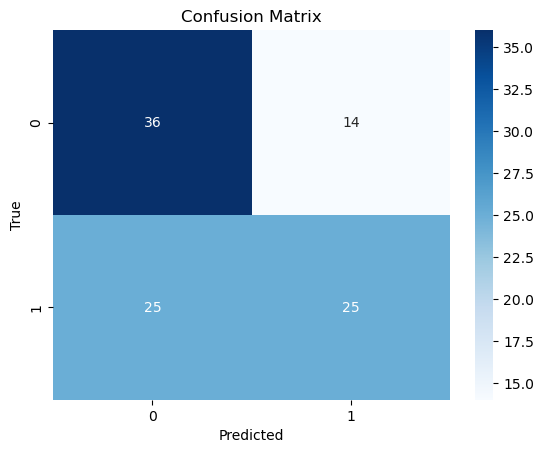

In [18]:
main('data/test')

### Common Voices Welsh Vs Avalingo-low

Audio Subdirsectories: ['cy', 'en2']
--------------------------
Extracting features from audio...
Processing cy...
Processing cy: 50/50 files (100.00% done)
Extracted features from cy, done
Processing en2...
Processing en2: 50/50 files (100.00% done)
Extracted features from en2, done
Audio Signals: (100, 64000)
Audio Labels: (100,)
--------------------------
Audio Features: (100, 126, 23)
Audio Labels: (100,)
--------------------------
Predicted labels: ['cy', 'en2', 'en2', 'en2', 'en2', 'cy', 'en2', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'en2', 'en2', 'cy', 'en2', 'cy', 'cy', 'cy', 'cy', 'en2', 'cy', 'cy', 'en2', 'en2', 'cy', 'en2', 'en2', 'cy', 'cy', 'cy', 'en2', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'cy', 'en2', 'en2', 'en2', 'en2', 'en2', 'cy', 'cy', 'en2', 'en2', 'cy', 'en2', 'cy', 'en2', 'cy', 'en2', 'en2', 'en2', 'en2', 'cy', 'cy', 'cy', 'cy', 'en2', 'en2', 'en2', 'cy', 'en2', 'cy', 'en2', 'en2', 'en2', 'en2', 'e

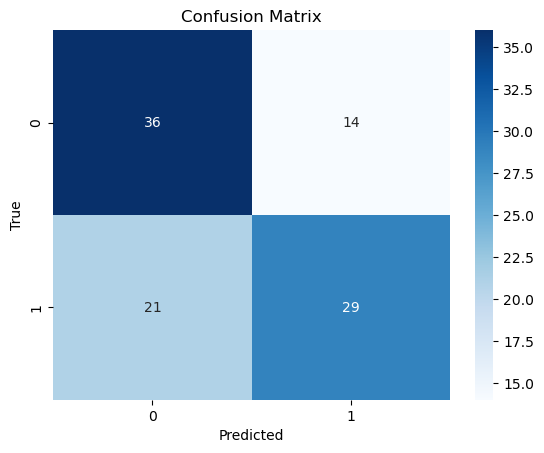

In [19]:
main('data/test2')